In [4]:
from google.colab import drive
drive.flush_and_unmount()
!rm -rf /content/drive/*
drive.mount('/content/drive')


Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# Directories for the images
benign_dir = "/content/drive/MyDrive/benignsegmented_final_SegNet_GA"
malignant_dir = "/content/drive/MyDrive/malignantsegmented_final_SegNet_GA"

# Load and preprocess images without removing black images
def load_images_from_folder(folder, label):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (128, 128))  # Resize to 128x128
            images.append((img, label))  # Append image and its label as tuple
    return images

# Load images
benign_images = load_images_from_folder(benign_dir, 0)  # Label 0 for benign
malignant_images = load_images_from_folder(malignant_dir, 1)  # Label 1 for malignant
# Function to manually calculate metrics
def calculate_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate precision, recall, specificity, and F1 score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, specificity, f1_score
# Data Augmentation
def augment_images(images, label):
    augmented_images = []
    for img, _ in images:
        # Horizontal flip
        flipped_img = cv2.flip(img, 1)
        augmented_images.append((flipped_img, label))

        # Rotation
        (h, w) = img.shape[:2]
        center = (w // 2, h // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, 15, 1.0)
        rotated_img = cv2.warpAffine(img, rotation_matrix, (w, h))
        augmented_images.append((rotated_img, label))

        # Brightness adjustment
        brightness_img = cv2.convertScaleAbs(img, alpha=1.1, beta=30)
        augmented_images.append((brightness_img, label))

        # Gaussian blur
        blurred_img = cv2.GaussianBlur(img, (5, 5), 0)
        augmented_images.append((blurred_img, label))

        # Contrast adjustment
        contrast_img = cv2.convertScaleAbs(img, alpha=1.5, beta=0)
        augmented_images.append((contrast_img, label))

    return augmented_images

# Apply augmentation to both benign and malignant images
augmented_benign_images = augment_images(benign_images, 0)  # Label 0 for benign
augmented_malignant_images = augment_images(malignant_images, 1)  # Label 1 for malignant

# Combine original and augmented images
data = benign_images  +augmented_benign_images+ malignant_images+augmented_malignant_images
X, y = zip(*data)  # Unzip the list of tuples into separate lists
X = np.array(X)
y = np.array(y)




In [6]:
# Normalize images for VGG-16
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
X = X / 255.0  # Scale pixel values to [0, 1]

# Reshape X to 128x128x3 for VGG-16 input (duplicate channels if grayscale)
X_reshaped = np.repeat(X, 3, axis=-1) if X.shape[-1] == 1 else X

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)


In [7]:
X_train.shape,X_test.shape

((15825, 128, 128, 3), (3957, 128, 128, 3))

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/50
495/495 [==============================] - 146s 292ms/step - loss: 0.5395 - accuracy: 0.7429 - val_loss: 0.4525 - val_accuracy: 0.7920
Epoch 2/50
495/495 [==============================] - 142s 287ms/step - loss: 0.4765 - accuracy: 0.7824 - val_loss: 0.4331 - val_accuracy: 0.7988
Epoch 3/50
495/495 [==============================] - 142s 287ms/step - loss: 0.4563 - accuracy: 0.7925 - val_loss: 0.4137 - val_accuracy: 0.8092
Epoch 4/50
495/495 [==============================] - 138s 280ms/step - loss: 0.4312 - accuracy: 0.8036 - val_loss: 0.3954 - val_accuracy: 0.8160
Epoch 5/50
495/495 [==============================] - 140s 283ms/step - loss: 0.4113 - accuracy: 0.8163 - val_loss: 0.3904 - val_accuracy: 0.8206
Epoch 6/50
495/495 [==============================] - 138s 279ms/step - loss: 0.3954 - accuracy: 0.8224 - val_loss: 0.3803 - val_accuracy: 0.8307
Epoch 7/50
495/495 [==============================] - 139s 

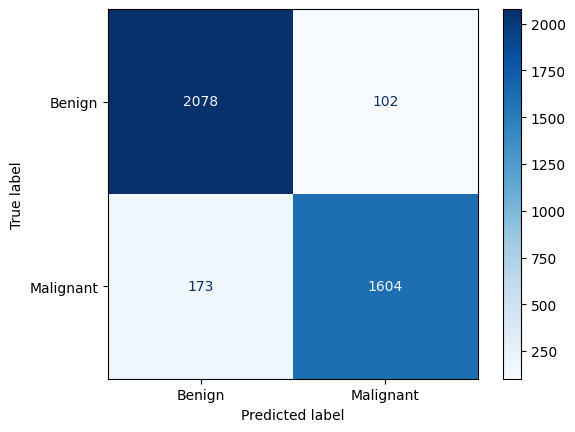

124/124 [==============================] - 29s 231ms/step - loss: 0.2479 - accuracy: 0.9305


0.9305028915405273

In [ ]:

# Load VGG-16 model with pre-trained weights, excluding the top (classification) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers to retain pre-trained weights
base_model.trainable = False

# Add custom classification layers on top of VGG-16
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout for regularization
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  # Sigmoid activation for binary classification

# Combine base and custom layers into the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])



# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test),batch_size=32)

# Predict and calculate metrics
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Function to manually calculate metrics
def calculate_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate precision, recall, specificity, and F1 score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, specificity, f1_score

# Calculate and display metrics
precision, recall, specificity, f1_score = calculate_metrics(y_test, y_pred)

print("Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot(cmap='Blues')
plt.show()
loss,accuracy=model.evaluate(X_test,y_test)
accuracy

Epoch 1/50
495/495 [==============================] - 145s 286ms/step - loss: 0.6087 - accuracy: 0.6871 - val_loss: 0.5485 - val_accuracy: 0.7341
Epoch 2/50
495/495 [==============================] - 135s 274ms/step - loss: 0.5677 - accuracy: 0.7359 - val_loss: 0.5311 - val_accuracy: 0.7533
Epoch 3/50
495/495 [==============================] - 133s 269ms/step - loss: 0.5491 - accuracy: 0.7419 - val_loss: 0.5117 - val_accuracy: 0.7589
Epoch 4/50
495/495 [==============================] - 135s 272ms/step - loss: 0.5366 - accuracy: 0.7513 - val_loss: 0.4947 - val_accuracy: 0.7875
Epoch 5/50
495/495 [==============================] - 134s 271ms/step - loss: 0.5200 - accuracy: 0.7654 - val_loss: 0.4831 - val_accuracy: 0.7880
Epoch 6/50
495/495 [==============================] - 133s 269ms/step - loss: 0.5061 - accuracy: 0.7700 - val_loss: 0.4693 - val_accuracy: 0.7935
Epoch 7/50
495/495 [==============================] - 134s 271ms/step - loss: 0.4938 - accuracy: 0.7767 - val_loss: 0.4647 -

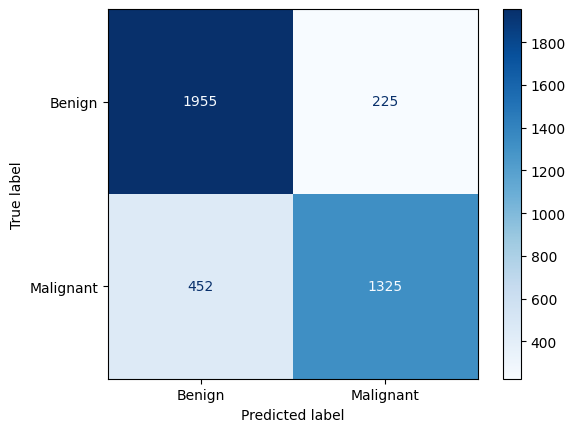

124/124 [==============================] - 27s 220ms/step - loss: 0.3932 - accuracy: 0.8289
Test Accuracy: 0.8289


In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load ResNet50 model with pre-trained weights, excluding the top (classification) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers to retain pre-trained weights
base_model.trainable = False

# Add custom classification layers on top of ResNet50
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout for regularization
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  # Sigmoid activation for binary classification

# Combine base and custom layers into the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Stop after 5 epochs of no improvement
    restore_best_weights=True  # Restore the best model weights
)

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=32,
    callbacks=[early_stopping]  # Include early stopping in the training process
)


# Predict and calculate metrics
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Function to manually calculate metrics
def calculate_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate precision, recall, specificity, and F1 score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, specificity, f1_score

# Calculate and display metrics
precision, recall, specificity, f1_score = calculate_metrics(y_test, y_pred)

print("Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot(cmap='Blues')
plt.show()

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
